In [1]:
import os
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
input_file = "../data/lora_meshtastic_modem_presets.sigmf-data"
if not Path(input_file).is_file():
    print(f"{input_file} is not a file")

In [3]:
input_metafile = input_file.replace("sigmf-data", "sigmf-meta")
print(f"Reading metadata from {input_metafile}")
with open(input_metafile, "r")  as f:
    meta = json.load(f)

sample_rate = meta["global"].get("core:sample_rate")
data_type = meta["global"].get("core:datatype")
center_frequency = meta["captures"][0].get("core:frequency")

print("Center Frequency:", center_frequency + 425391)
print("Data type:", data_type)
print(f"Sample rate: {sample_rate/1e6:.3f} MS/s")

item_size = {"cu8_le":1, "cf32_le":8}[data_type]
total_samples = os.path.getsize(input_file) // item_size

print("Total samples:", total_samples)
print(f"Duration: {total_samples/sample_rate:.2f} s")

Reading metadata from ../data/lora_meshtastic_modem_presets.sigmf-meta
Center Frequency: 869950782
Data type: cu8_le
Sample rate: 0.300 MS/s
Total samples: 2953258
Duration: 9.84 s


In [4]:
def cu8_to_fc32(data: np.ndarray) -> np.ndarray:
    if len(data) % 2 != 0:
        raise ValueError("Input data length must be even (interleaved I/Q)")
    
    real_part = data[0::2].astype(np.float32)
    imag_part = data[1::2].astype(np.float32)
    
    real_part = (real_part / 127.5) - 1.0
    imag_part = (imag_part / 127.5) - 1.0
    
    return (real_part + 1j * imag_part).astype(np.complex64)

iq_cu8_tmp = np.fromfile(input_file, 'uint8')
iq_fc32 = cu8_to_fc32(iq_cu8_tmp)
del iq_cu8_tmp
print(f"Recording has {len(iq_fc32)} samples")

Recording has 1476629 samples


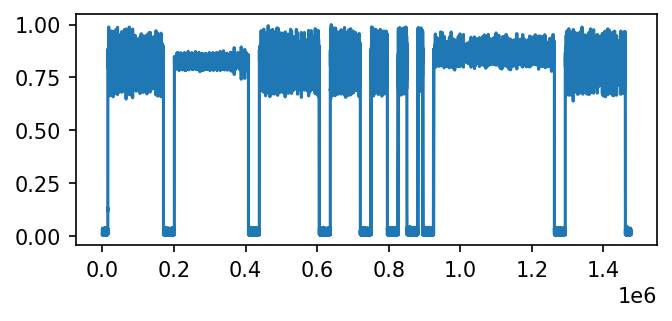

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=150)

plt.plot(np.abs(iq_fc32[0:-1]))
plt.show()

In [6]:
# Find the Packet edges
# Compute magnitude and create boolean mask
mag = np.abs(iq_fc32)
threshold = 0.05
min_length = 100
start_padding = end_padding = 200
above_thresh = mag > threshold

# Find transitions using diff
transitions = np.diff(above_thresh.astype(int))
rising_edges = np.where(transitions == 1)[0] + 1  # +1 because diff shifts indices
falling_edges = np.where(transitions == -1)[0] + 1

# Handle edge cases: signal starts/ends above threshold
if above_thresh[0]:
    rising_edges = np.concatenate(([0], rising_edges))
if above_thresh[-1]:
    falling_edges = np.concatenate((falling_edges, [len(iq_fc32)]))

# Pair rising and falling edges
packets = []
for start, end in zip(rising_edges, falling_edges):
    if end - start >= min_length:  # Filter short spurious packets
        packets.append((start - start_padding, end + end_padding))

for i,packet in enumerate(packets):
    t_start = packet[0]/sample_rate
    t_end = packet[1]/sample_rate
    duration = t_end - t_start
    print(f"Packet {i+1}: {t_start:5.2f} to {t_end:5.2f} seconds - ({duration*1000:7.2f} ms)")

Packet 1:  0.05 to  0.57 seconds - ( 519.89 ms)
Packet 2:  0.67 to  1.36 seconds - ( 691.74 ms)
Packet 3:  1.46 to  2.02 seconds - ( 560.85 ms)
Packet 4:  2.12 to  2.40 seconds - ( 281.28 ms)
Packet 5:  2.50 to  2.66 seconds - ( 151.75 ms)
Packet 6:  2.76 to  2.84 seconds - (  81.87 ms)
Packet 7:  2.94 to  2.98 seconds - (  46.92 ms)
Packet 8:  3.08 to  4.21 seconds - (1126.94 ms)
Packet 9:  4.31 to  4.87 seconds - ( 560.84 ms)


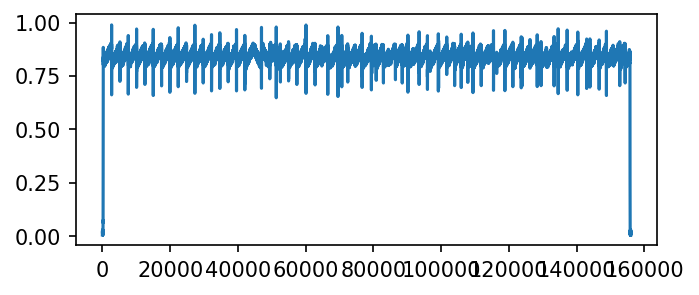

In [7]:
packet = packets[0]
packet_iq = iq_fc32[packet[0]:packet[1]]

fig, ax = plt.subplots(1, 1, figsize=(5,2), dpi=150)
plt.plot(np.abs(packet_iq))
plt.show()

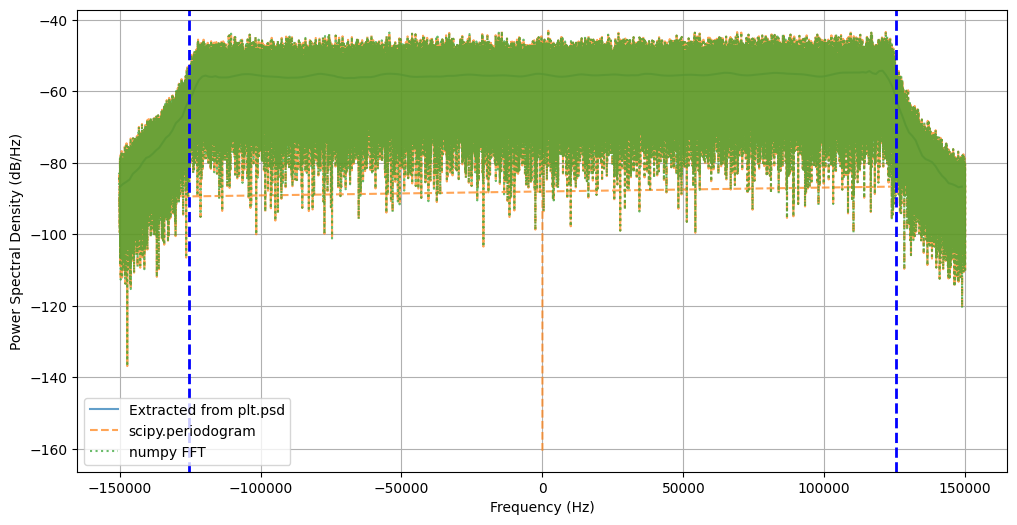

In [8]:
# Excessively plot the bandwidth of the signal using multiple methods for fun and education

# Method 1: Extract from matplotlib plot
fig, ax = plt.subplots()
Pxx_plot, freqs_plot = ax.psd(packet_iq, Fs=sample_rate)
plt.close(fig)  # Close the plot if you don't want to display it
Pxx_plot_db = 10 * np.log10(Pxx_plot)

# Method 2: Calculate directly using scipy.signal.periodogram
freqs_calc, psd_calc = signal.periodogram(packet_iq, fs=sample_rate)
psd_calc_db = 10 * np.log10(psd_calc)  # Convert to dB

# Method 3: Calculate using numpy FFT (similar to what matplotlib does internally)
fft_data = np.fft.fft(packet_iq)
freqs_fft = np.fft.fftfreq(len(packet_iq), 1/sample_rate)
psd_fft = np.abs(fft_data)**2 / (sample_rate * len(packet_iq))
psd_fft_db = 10 * np.log10(psd_fft)

# Find the 10 dB bandwidth
bw_indices = np.where(Pxx_plot_db >= Pxx_plot_db.max() - 10)[0][[0, -1]]

# Compare the methods
fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.plot(freqs_plot, Pxx_plot_db, label='Extracted from plt.psd', alpha=0.7)
plt.plot(freqs_calc, psd_calc_db, label='scipy.periodogram', linestyle='--', alpha=0.7)
plt.plot(np.fft.fftshift(freqs_fft), np.fft.fftshift(psd_fft_db), label='numpy FFT', linestyle=':', alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (dB/Hz)')
for i in bw_indices:
    ax.axvline(freqs_plot[i], linestyle='--', linewidth=2, color='blue')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
bw_edges = freqs_plot[bw_indices]
bandwidth = bw_edges[1] - bw_edges[0]
freq_center = np.sum(bw_edges)/2

print(f"Bandwidth: {bandwidth/1000:.3f} kHz")
print(f"Center Frequency: {freq_center/1000:.3f} kHz")

Bandwidth: 250.781 kHz
Center Frequency: 0.000 kHz


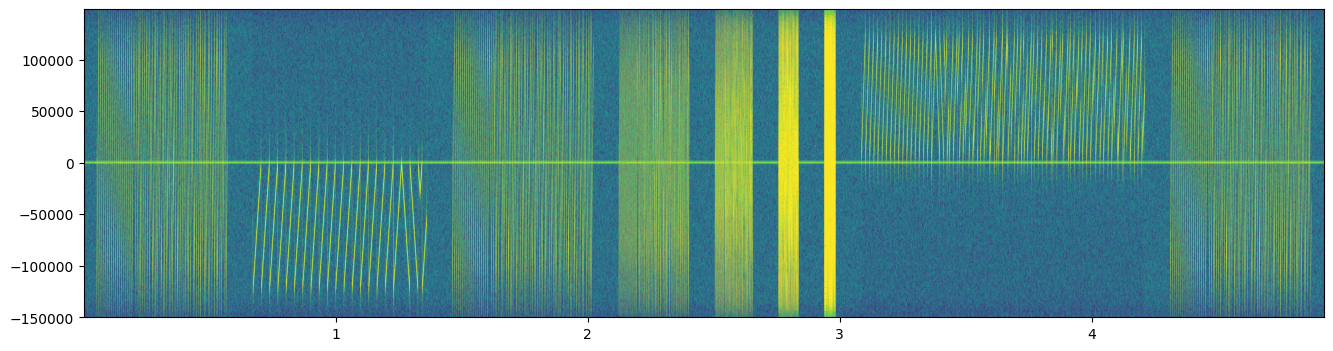

In [10]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.specgram(iq_fc32, Fs=sample_rate, vmin=-110, vmax=-70)
plt.show()

In [11]:
phase = np.unwrap(np.angle(iq_fc32))
inst_freq = np.diff(phase) * sample_rate / (2 * np.pi)

Duration: 179.92 ms


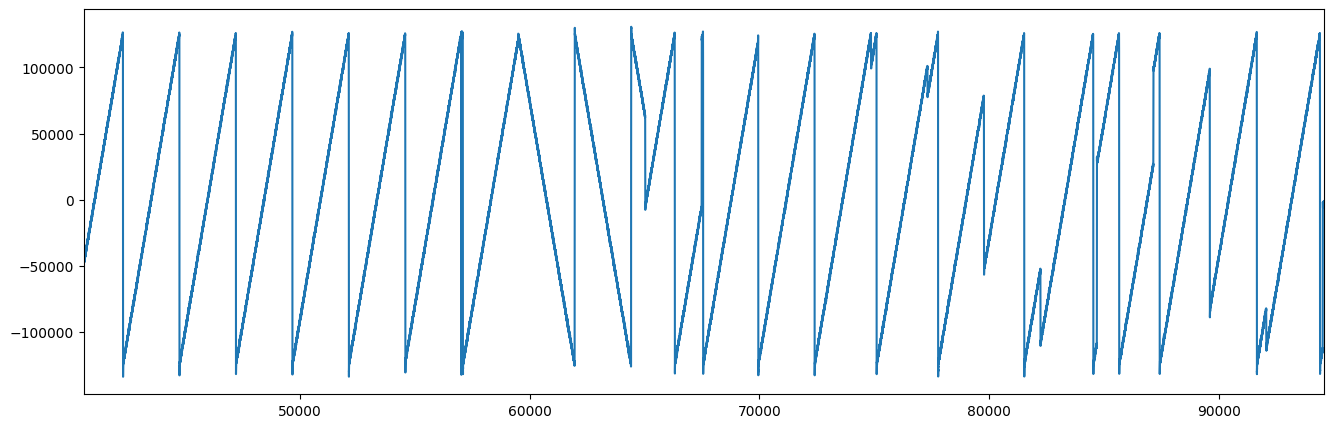

In [12]:
fig, ax = plt.subplots(1,1,figsize=(16,5))

samps_per_symbol = 3175
sps = samps_per_symbol
samps_to_zero_symbol = 15200
first_symbol = 8
last_symbol = 25

start_idx = int(samps_to_zero_symbol + first_symbol * samps_per_symbol)
end_idx   = int(start_idx + (last_symbol-first_symbol) * samps_per_symbol)
slice = inst_freq[start_idx:end_idx]

# Preamble (6-65536 symbols)
preamble_start = samps_to_zero_symbol
preamble_end = 19 * sps
# Start Frame Delimiter (2.25 symbols)
sfd_start = preamble_end
sfd_end = sfd_start + 2.25 * sps
# Header (optional)
# Payload 
payload_start = sfd_end
payload_end = payload_start + 30 * sps

print(f"Duration: {(len(slice)/sample_rate)*1000:.2f} ms")
t = np.arange(len(slice)) / sample_rate
ax.plot(np.arange(start_idx, end_idx), slice)

#ax.axvspan(preamble_start, preamble_end, color='green', alpha=0.1, lw=0)
#ax.axvspan(sfd_start, sfd_end, color="yellow", alpha=0.1, lw=0)
#ax.axvspan(payload_start, payload_end, color="purple", alpha=0.1, lw=0)

ax.set_xlim([start_idx, end_idx])
plt.show()

In [13]:
keys = ["data_rate", "sf", "symbols", "coding_rate", "bandwidth"]
data = [
    ("Short Turbo",  21.88,  7,  128, "4/5", 500e3),
    ("Short Fast",   10.94,  7,  128, "4/5", 250e3),
    ("Short Slow",    6.25,  8,  256, "4/5", 250e3),
    ("Medium Fast",   3.52,  9,  512, "4/5", 250e3),
    ("Medium Slow",   1.95, 10, 1024, "4/5", 250e3),
    ("Long Fast",     1.07, 11, 2048, "4/5", 250e3),
    ("Long Moderate", 0.34, 11, 2048, "4/8", 125e3),
    ("Long Slow",     0.18, 12, 4096, "4/8", 125e3)
]
modem_presets = {name: dict(zip(keys, values)) for name, *values in data}

In [14]:
current_modem = "Long Fast"
modem = modem_presets[current_modem]

expected_symbol_rate = modem["bandwidth"] / 2**modem["sf"]
expected_data_rate   = modem["bandwidth"] * modem["sf"] / 2**modem["sf"]
expected_chirp_duration = 1/expected_symbol_rate

print(f"Expected Chirp Duration: {expected_chirp_duration*1000:.2f} ms")
expected_chirp_rate = modem["bandwidth"] / expected_chirp_duration
print(f"Expected Chirp Rate: {expected_chirp_rate/1e6:.2f} MHz/s")

Expected Chirp Duration: 8.19 ms
Expected Chirp Rate: 30.52 MHz/s


Average Chirp Rate: 30.4594 MHz/s


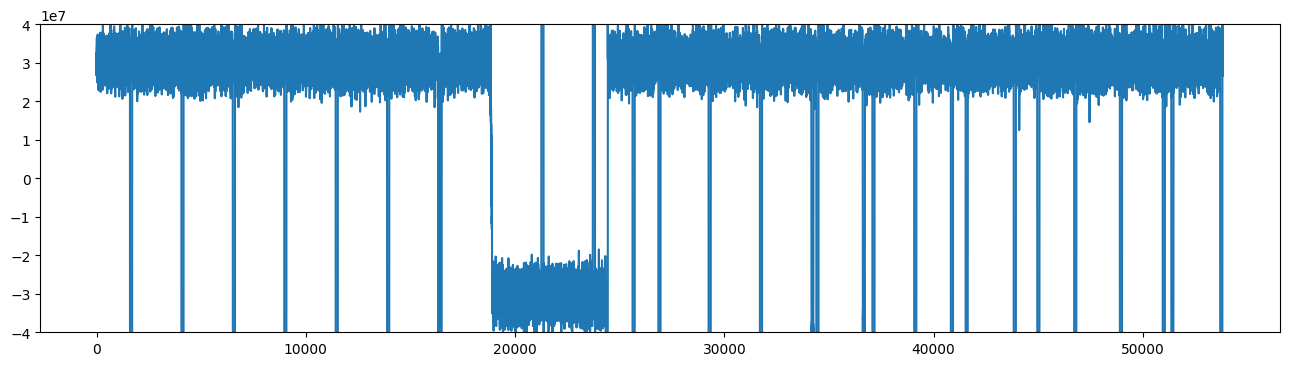

In [15]:
window_size = 100

weights = np.ones(window_size) / window_size
sma = np.convolve(slice, weights, mode='valid')

chirp_rate = np.diff(sma) * sample_rate

print(f"Average Chirp Rate: {np.median(chirp_rate[100:1200])/1e6:.4f} MHz/s")

fig, ax = plt.subplots(1,1, figsize=(16,4))
ax.plot(chirp_rate[0:-1:1])
ax.set_ylim([-40e6, 40e6])
plt.show()


In [16]:
def generate_chirp(sf, bandwidth, sample_rate, duration, up_chirp=True):
    """
    Generate a chirp signal (up-chirp or down-chirp)
    
    Args:
        sf: Spreading factor
        bandwidth: Bandwidth in Hz24752475
        sample_rate: Sample rate in Hz
        duration: Duration in seconds
        up_chirp: True for up-chirp, False for down-chirp
    
    Returns:
        Complex chirp signal
    """
    # Time vector
    t = np.arange(0, duration, 1/sample_rate)
    
    # Chirp rate (frequency change per second)
    chirp_rate = bandwidth / duration if up_chirp else -bandwidth / duration
    
    # Start frequency (for up-chirp: -BW/2, for down-chirp: +BW/2)
    f0 = -bandwidth/2 if up_chirp else bandwidth/2
    
    # Generate chirp: frequency = f0 + chirp_rate * t
    # Phase = integral of 2*pi*frequency = 2*pi*(f0*t + 0.5*chirp_rate*t^2)
    phase = 2 * np.pi * (f0 * t + 0.5 * chirp_rate * t**2)
    
    return np.exp(1j * phase)

def generate_lora_preamble_sfd(sf, bandwidth, sample_rate):
    """
    Generate LoRa preamble and SFD reference signal
    
    Args:
        sf: Spreading factor
        bandwidth: Bandwidth in Hz
        sample_rate: Sample rate in Hz
    
    Returns:
        tuple: (preamble_sfd_signal, symbol_duration, sfd_end_sample)
    """
    # Calculate symbol duration
    symbol_duration = (2**sf) / bandwidth
    
    print(f"Symbol duration: {symbol_duration*1000:.2f} ms")
    print(f"Samples per symbol: {symbol_duration * sample_rate:.1f}")
    
    # Generate preamble (2 up-chirp symbols)
    preamble = []
    for i in range(2):
        chirp = generate_chirp(sf, bandwidth, sample_rate, symbol_duration, up_chirp=True)
        preamble.extend(chirp)
    
    # Generate SFD (2.25 down-chirp symbols)
    sfd = []
    # First 2 complete down-chirp symbols
    for i in range(2):
        chirp = generate_chirp(sf, bandwidth, sample_rate, symbol_duration, up_chirp=False)
        sfd.extend(chirp)
    
    # Add 0.25 of a down-chirp symbol
    partial_chirp = generate_chirp(sf, bandwidth, sample_rate, 0.25 * symbol_duration, up_chirp=False)
    sfd.extend(partial_chirp)
    
    # Combine preamble and SFD
    preamble_sfd = np.array(preamble + sfd, dtype=np.complex64)
    
    # Calculate where SFD ends (start of payload)
    sfd_end_sample = len(preamble_sfd)
    
    return preamble_sfd, symbol_duration, sfd_end_sample

def detect_sfd_end(packet_iq, sf, bandwidth, sample_rate, plot=False):
    """
    Detect the end of SFD (start of payload) in a LoRa packet
    
    Args:
        packet_iq: Complex IQ samples of the received packet
        sf: Spreading factor
        bandwidth: Bandwidth in Hz
        sample_rate: Sample rate in Hz
        plot: Whether to plot the correlation result
    
    Returns:
        int: Sample index where payload begins
    """
    # Generate reference preamble + SFD signal
    ref_signal, symbol_duration, ref_sfd_end = generate_lora_preamble_sfd(sf, bandwidth, sample_rate)
    
    print(f"Reference signal length: {len(ref_signal)} samples ({len(ref_signal)/sample_rate*1000:.1f} ms)")
    plt.specgram(ref_signal, Fs=sample_rate)
    plt.show()
    # Cross-correlate with received signal
    # Use 'valid' mode to avoid edge effects
    correlation = np.correlate(packet_iq, ref_signal, mode='valid')
    
    # Find peak correlation
    peak_idx = np.argmax(np.abs(correlation))
    
    # The SFD ends at: peak position + reference signal length
    sfd_end_idx = peak_idx + len(ref_signal)
    
    print(f"Peak correlation at sample: {peak_idx}")
    print(f"SFD ends at sample: {sfd_end_idx}")
    print(f"Correlation peak magnitude: {np.abs(correlation[peak_idx]):.2f}")
    
    if plot:
        plt.figure(figsize=(12, 8))
        
        # Plot correlation magnitude
        plt.subplot(3, 1, 1)
        plt.plot(np.abs(correlation))
        plt.axvline(x=peak_idx, color='r', linestyle='--', label=f'Peak at {peak_idx}')
        plt.title('Cross-correlation Magnitude')
        plt.xlabel('Sample')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        
        # Plot received signal magnitude around detection point
        plt.subplot(3, 1, 2)
        start_plot = max(0, peak_idx - 1000)
        end_plot = min(len(packet_iq), sfd_end_idx + 1000)
        plt.plot(np.abs(packet_iq[start_plot:end_plot]))
        plt.axvline(x=peak_idx-start_plot, color='g', linestyle='--', label='Preamble start')
        plt.axvline(x=sfd_end_idx-start_plot, color='r', linestyle='--', label='SFD end (payload start)')
        plt.title('Received Signal Magnitude')
        plt.xlabel('Sample (relative)')
        plt.ylabel('Magnitude')
        plt.legend()
        plt.grid(True)
        
        # Plot reference signal
        plt.subplot(3, 1, 3)
        plt.plot(np.abs(ref_signal))
        plt.title('Reference Preamble + SFD Signal')
        plt.xlabel('Sample')
        plt.ylabel('Magnitude')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    return sfd_end_idx

LoRa parameters: SF=11, BW=250.0kHz, Fs=300.0kHz
Symbol duration: 8.19 ms
Samples per symbol: 2457.6

Test packet length: 17447 samples
Expected SFD end at sample: 12447
Symbol duration: 8.19 ms
Samples per symbol: 2457.6
Reference signal length: 10447 samples (34.8 ms)


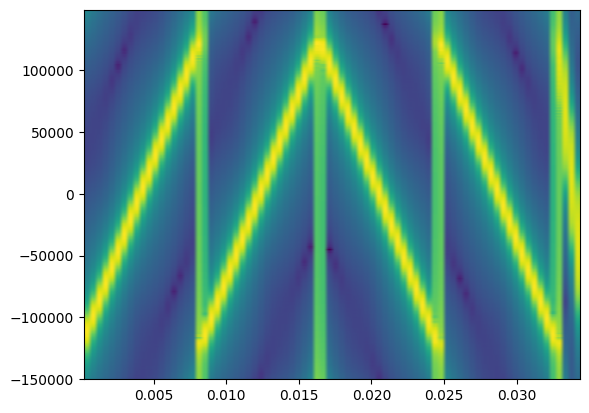

Peak correlation at sample: 2000
SFD ends at sample: 12447
Correlation peak magnitude: 10444.47


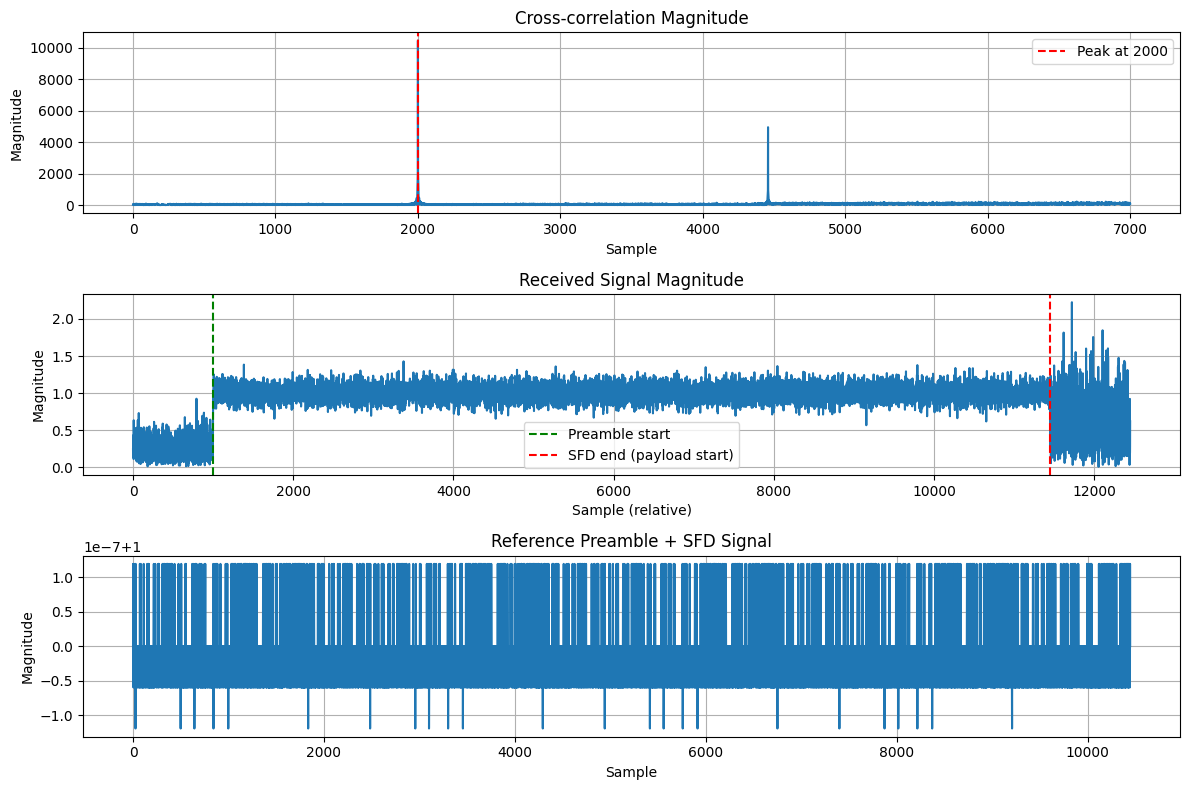


Detection error: 0 samples (0.00 ms)


In [17]:
# Test the above correlation code
sf = 11          # Spreading factor
bandwidth = 250000  # 125 kHz
sample_rate = sample_rate  # 300 kHz

print(f"LoRa parameters: SF={sf}, BW={bandwidth/1000}kHz, Fs={sample_rate/1000}kHz")

# Generate a test packet (preamble + SFD + some payload)
ref_signal, symbol_duration, _ = generate_lora_preamble_sfd(sf, bandwidth, sample_rate)

# Add some noise and a fake payload
noise = 0.1 * (np.random.randn(len(ref_signal)) + 1j * np.random.randn(len(ref_signal)))
fake_payload = 0.5 * (np.random.randn(5000) + 1j * np.random.randn(5000))

# Create test packet: some leading noise + preamble/SFD + payload
leading_samples = 2000
leading_noise = 0.2 * (np.random.randn(leading_samples) + 1j * np.random.randn(leading_samples))

test_packet = np.concatenate([leading_noise, ref_signal + noise, fake_payload])
test_packet = test_packet.astype(np.complex64)

print(f"\nTest packet length: {len(test_packet)} samples")
print(f"Expected SFD end at sample: {leading_samples + len(ref_signal)}")

# Detect SFD end
detected_sfd_end = detect_sfd_end(test_packet, sf, bandwidth, sample_rate, plot=True)

# Check accuracy
expected_sfd_end = leading_samples + len(ref_signal)
error = abs(detected_sfd_end - expected_sfd_end)
print(f"\nDetection error: {error} samples ({error/sample_rate*1000:.2f} ms)")

Symbol duration: 8.19 ms
Samples per symbol: 2457.6
Reference signal length: 10447 samples (34.8 ms)


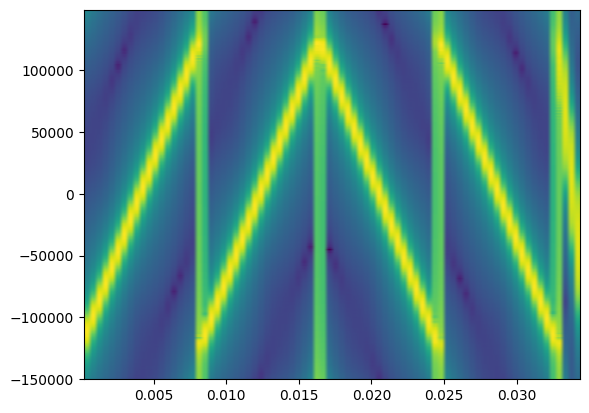

Peak correlation at sample: 34671
SFD ends at sample: 45118
Correlation peak magnitude: 3809.56


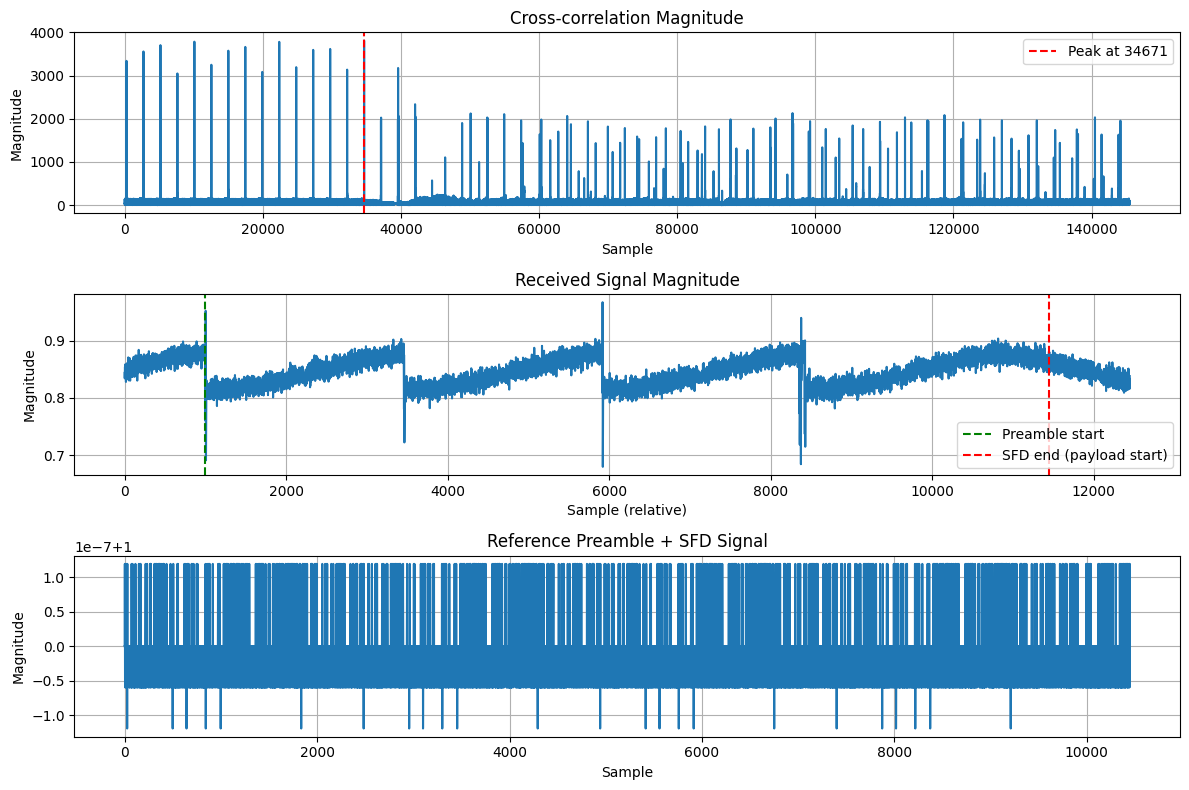

In [18]:
test_packet = packet_iq
sf = 11
bandwidth = 250e3
sample_rate = sample_rate

detected_sfd_end = detect_sfd_end(test_packet, sf, bandwidth, sample_rate, plot=True)